# Hands-on Workshop - *Predicting product ratings from reviews*

This workshop is focused on the creation, deployment, monitoring and management of a machine learning model for predicting product ratings from reviews.

### Tom - this isn't completely relevant anymore, will change it before workshop to talk about pretrained model being used etc, so just ignore for now

In this notebook we will be exploring the data, and training the machine learning model itself; in the form of a Tensorflow Keras model. We will then deploy a second Tensorflow model with differing architecture as a Canary model to demonstrate the A/B testing functionality Seldon provides. Then we will begin to add the advanced monitoring and explainability that Seldon Alibi is famed for. 

-----------------------------------
Firstly, we will install and import the relevant packages which we will use throughout the exploration, training, and deployment process. 

In [1]:
!pip install transformers
!pip install seldon_deploy_sdk
!pip install alibi==0.6.4
!pip install alibi_detect==0.8.1
!pip install datasets

You should consider upgrading via the '/home/seldon/PycharmProjects/deploy-workshops/venv/nlp-ratings/bin/python -m pip install --upgrade pip' command.
  Using cached seldon_deploy_sdk-1.5.0-py3-none-any.whl (807 kB)
  Using cached Authlib-0.15.5-py2.py3-none-any.whl (203 kB)
You should consider upgrading via the '/home/seldon/PycharmProjects/deploy-workshops/venv/nlp-ratings/bin/python -m pip install --upgrade pip' command.
  Using cached alibi-0.6.4-py3-none-any.whl (397 kB)
     |████████████████████████████████| 3.1 MB 3.3 MB/s            
     |████████████████████████████████| 14.0 MB 12.3 MB/s            
     |████████████████████████████████| 26.7 MB 15.9 MB/s            
     |████████████████████████████████| 6.5 MB 10.5 MB/s            
     |████████████████████████████████| 11.3 MB 7.6 MB/s            
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached fonttools-4.33.3-py3-none-any.whl (930 kB)


     |████████████████████████████████| 1.2 MB 16.7 MB/s            
     |████████████████████████████████| 195 kB 15.8 MB/s            
     |████████████████████████████████| 6.9 MB 12.2 MB/s            
     |████████████████████████████████| 2.0 MB 13.5 MB/s            
  Using cached imageio-2.19.3-py3-none-any.whl (3.4 MB)
     |████████████████████████████████| 459 kB 12.3 MB/s            
     |████████████████████████████████| 13.7 MB 392 kB/s             
     |████████████████████████████████| 10.2 MB 13.8 MB/s            
  Using cached wasabi-0.9.1-py3-none-any.whl (26 kB)
     |████████████████████████████████| 671 kB 11.6 MB/s            
  Using cached spacy_legacy-3.0.9-py2.py3-none-any.whl (20 kB)
  Using cached typer-0.4.1-py3-none-any.whl (27 kB)
     |████████████████████████████████| 130 kB 3.4 MB/s            
  Using cached spacy_loggers-1.0.2-py3-none-any.whl (7.2 kB)
  Using cached catalogue-2.0.7-py3-none-any.whl (17 kB)
  Using cached pathy-0.6.1-py3-none-a

  Using cached smart_open-5.2.1-py3-none-any.whl (58 kB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.1.1
    Uninstalling scikit-learn-1.1.1:
      Successfully uninstalled scikit-learn-1.1.1
You should consider upgrading via the '/home/seldon/PycharmProjects/deploy-workshops/venv/nlp-ratings/bin/python -m pip install --upgrade pip' command.
  Using cached alibi_detect-0.8.1-py3-none-any.whl (311 kB)
     |████████████████████████████████| 3.1 MB 4.0 MB/s            
     |████████████████████████████████| 3.4 MB 12.6 MB/s            


  Using cached tensorflow_probability-0.12.2-py2.py3-none-any.whl (4.8 MB)
     |████████████████████████████████| 30.2 MB 14.5 MB/s            
  Using cached opencv_python-4.6.0.66-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (60.9 MB)
     |████████████████████████████████| 34.5 MB 11.9 MB/s            


  Using cached decorator-5.1.1-py3-none-any.whl (9.1 kB)
     |████████████████████████████████| 142 kB 16.1 MB/s            
  Using cached cloudpickle-2.1.0-py3-none-any.whl (25 kB)
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.1.1
    Uninstalling Pillow-9.1.1:
      Successfully uninstalled Pillow-9.1.1
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.19.3
    Uninstalling scikit-image-0.19.3:
      Successfully uninstalled scikit-image-0.19.3
You should consider upgrading via the '/home/seldon/PycharmProjects/deploy-workshops/venv/nlp-ratings/bin/python -m pip install --upgrade pip' command.


You should consider upgrading via the '/home/seldon/PycharmProjects/deploy-workshops/venv/nlp-ratings/bin/python -m pip install --upgrade pip' command.


In [7]:
import numpy as np
import pandas as pd 
import datasets

import tensorflow as tf
from transformers import AutoTokenizer, create_optimizer, DefaultDataCollator, TFAutoModelForSequenceClassification

from sklearn.model_selection import train_test_split

from seldon_deploy_sdk import Configuration, ApiClient, SeldonDeploymentsApi, ModelMetadataServiceApi, DriftDetectorApi, BatchJobsApi, BatchJobDefinition
from seldon_deploy_sdk.auth import OIDCAuthenticator

In [3]:
# Check available GPUs

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## Get Data

In [4]:
!gsutil cp gs://kelly-seldon/nlp-ratings/review_data.csv review_data.csv

Copying gs://kelly-seldon/nlp-ratings/review_data.csv...
\ [1 files][ 11.3 MiB/ 11.3 MiB]                                                
Operation completed over 1 objects/11.3 MiB.                                     


In [12]:
df = pd.read_csv("review_data.csv", delimiter=";")
df.head()

,product,user_id,rating,review,date_created
0,Product 65359,27604,5.0,"_product_ provided me with a pretty good, sec...",2020-04-05 15:51:09
1,Product 34804,152368,4.0,it protects our files and computer and very si...,2019-06-24 00:40:54
2,Product 18042,1212264,5.0,"like most businesses, we are always looking fo...",2016-11-24 13:29:07
3,Product 2179,1383,3.0,we believed _product_ was a great solution for...,2019-09-21 14:02:50
4,Product 90712,92494,4.0,i formerly used _product_ and was relieved to ...,2018-11-28 05:37:54


## Preprocess Data

Can we do more here? Remove punctuation etc? What does the pretrained tokenizer do?

In [13]:
df['review'] = df['review'].astype(str)
df['rating'] = df['rating'].astype(str)

rating_mapping = {
    '1.0': 0,
    '1.5': 1,
    '2.0': 2,
    '2.5': 3,
    '3.0': 4,
    '3.5': 5,
    '4.0': 6, 
    '4.5': 7,
    '5.0': 8
}

df['label'] = df['rating'].apply(lambda x: rating_mapping[x])
df.drop(columns=['product', 'user_id', 'date_created', 'rating'], axis=1, inplace=True)

df.head()

,review,label
0,"_product_ provided me with a pretty good, sec...",8
1,it protects our files and computer and very si...,6
2,"like most businesses, we are always looking fo...",8
3,we believed _product_ was a great solution for...,4
4,i formerly used _product_ and was relieved to ...,6


In [14]:
df["label"].value_counts()

8    31721
6    14017
4     2645
0      763
2      625
7      150
5       27
3       27
1       25
Name: label, dtype: int64

In [17]:
# Split data into train and test sets
train, test = train_test_split(df, test_size=0.3, random_state=42)

In [18]:
# Convert data into Dataset type
train_ds = datasets.Dataset.from_pandas(train, preserve_index=False)
test_ds = datasets.Dataset.from_pandas(test, preserve_index=False)
comp_ds = datasets.DatasetDict({"train":train_ds,"test":test_ds})

In [19]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [24]:
def preprocess_function(df):
    return tokenizer(df["review"], padding="max_length", truncation=True)

In [27]:
tokenized_revs = comp_ds.map(preprocess_function, batched=True)

  0%|          | 0/35 [00:00<?, ?ba/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

In [28]:
data_collator = DefaultDataCollator(return_tensors="tf")

In [29]:
tf_train_set = tokenized_revs["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["labels"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator
)

tf_test_set = tokenized_revs["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["labels"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator
)

In [30]:
model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=9)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

In [31]:
model.layers[0].trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)

model.fit(tf_train_set, validation_data=tf_test_set, epochs=5)

Epoch 1/5
   2/2187 [..............................] - ETA: 3:03:32 - loss: 2.1506 - sparse_categorical_accuracy: 0.2812

KeyboardInterrupt: 

In [3]:
# reviews = []
# labels = []

# for row in df.iterrows():
#     labels.append(row[1]['label'])
#     review = row[1]['review']
#     for word in STOPWORDS:
#         token = ' ' + word + ' '
#         review = review.replace(token, ' ')
#         review = review.replace(' ', ' ')
#     reviews.append(review)
# print(len(labels))
# print(len(reviews))

50000
50000


## Evaluation

In [275]:
# colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# mpl.rcParams['figure.figsize'] = (12, 10)

In [276]:
# def plot_metrics(history):
#     metrics = ['loss', 'accuracy']
#     for n, metric in enumerate(metrics):
#         name = metric.replace("_"," ").capitalize()
#         plt.subplot(2,2,n+1)
#         plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
#         plt.plot(history.epoch, history.history['val_'+metric],
#                  color=colors[0], linestyle="--", label='Val')
#         plt.xlabel('Epoch')
#         plt.ylabel(name)
#         if metric == 'loss':
#             plt.ylim([0, plt.ylim()[1]])
#         elif metric == 'auc':
#             plt.ylim([0.8,1])
#         else:
#             plt.ylim([0,1])

#         plt.legend();

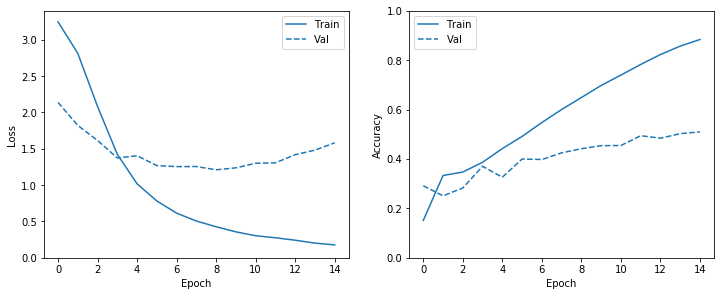

In [286]:
# plot_metrics(history)

In [287]:
# int_loss, int_accuracy = int_model.evaluate(int_test_ds[0], int_test_ds[1])

# print("Int model accuracy: {:2.2%}".format(int_accuracy))

157/157 [==============================] - 0s 1ms/step - loss: 1.5388 - accuracy: 0.5240
Int model accuracy: 52.40%


In [288]:
# predictions = int_model.predict(int_test_ds[0])
# print(predictions[:1])

[[-12.551326   -14.205595   -10.307593    -6.996902    -6.236613
  -11.317929    14.247541     0.38065982  15.718541  ]]


In [289]:
# print(predictions)

[[-12.551326   -14.205595   -10.307593   ...  14.247541     0.38065982
   15.718541  ]
 [ -2.5539522  -11.087661     2.168796   ...   0.59642243  -8.97046
    5.491527  ]
 [-14.290668   -13.789915    -4.7460256  ...  11.998764     1.4773175
   13.5251255 ]
 ...
 [-16.912428   -18.866726   -10.535642   ...   7.2865367   -3.2117934
   10.618746  ]
 [ -7.1668673  -10.601623    -6.650805   ...  -4.0072656   -5.804961
   -0.5142288 ]
 [ -3.5702062   -6.9096284   -2.2240076  ...  -1.6571041   -4.138695
    0.28596228]]


In [290]:
# test_re = int_test_ds[1].reset_index(drop=True)

In [291]:
# test_val_list = []
# pred_val_list = []

# for i in range(0,len(test_re)):
#     test_val = test_re[i]
#     test_val_list.append(test_val)
#     pred_val = list(predictions[i]).index(predictions[i].max())
#     pred_val_list.append(pred_val)

In [292]:
# df_results = pd.DataFrame(
#         {'Test_val':test_val_list,
#             'Pred_val':pred_val_list}

# )

In [293]:
# df_results

,Test_val,Pred_val
0,2,8
1,6,8
2,8,8
3,8,8
4,8,6
...,...,...
4995,8,8
4996,8,6
4997,8,8
4998,6,8


In [294]:
# df_results['match']='False'
# df_results.loc[df_results['Test_val']==df_results['Pred_val'],'match'] = 'True'

In [295]:
# df_group = df_results.groupby(['Test_val','match']).count()

In [296]:
# df_results['Pred_val'].value_counts(normalize=True)

8    0.6066
6    0.3024
4    0.0510
0    0.0196
2    0.0166
7    0.0024
3    0.0008
5    0.0004
1    0.0002
Name: Pred_val, dtype: float64

In [298]:
# df_group

Pred_val
Test_val match          
0        False        55
         True         26
1        False         1
2        False        46
         True          5
4        False       246
         True         37
5        False         1
         True          1
6        False       901
         True        472
7        False        14
         True          1
8        False      1116
         True       2078

## Evaluation if accuracy not provided as metric when training

In [ ]:
y_preds = model.predict(tf_train_set)

In [ ]:
y_preds["logits"][3000]

In [ ]:
rating_preds = []
for i in y_preds["logits"]:
    rating_preds.append(np.argmax(i, axis=0))

In [ ]:
print('accuracy %s' % accuracy_score(rating_preds, test["label"]))

## Model Deployment

You can now deploy your model to the dedicated Seldon Deploy cluster which we have configured for this workshop. To do so you will interact with the Seldon Deploy SDK and deploy your model using that.

First, setting up the configuration and authentication required to access the cluster. Make sure to fill in the `SD_IP` variable to be the same as the cluster you are using.

In [8]:
SD_IP = "34.141.146.222"

config = Configuration()
config.host = f"http://{SD_IP}/seldon-deploy/api/v1alpha1"
config.oidc_client_id = "sd-api"
config.oidc_server = f"http://{SD_IP}/auth/realms/deploy-realm"
config.oidc_client_secret = "sd-api-secret"
config.auth_method = "client_credentials"

def auth():
    auth = OIDCAuthenticator(config)
    config.id_token = auth.authenticate()
    api_client = ApiClient(configuration=config, authenticator=auth)
    return api_client

Now you have configured the IP correctly as well as setup your authentication function you can describe the deployment you would like to create. 

You will need to fill in the `YOUR_NAME` variable. This MUST be lower case as it will be used for the `DEPLOYMENT_NAME` variable later on.

The `MODEL_NAME` and `MODEL_PATH` variables have been prefilled for you as we are using a pretrained model and a pre-built container image for the sake of saving time in the workshop. 

The rest of the `mldeployment` description has been completed for you.


In [10]:
YOUR_NAME = "kellyspry"
MODEL_NAME = "review-ratings"

DEPLOYMENT_NAME = f"{YOUR_NAME}-{MODEL_NAME}"
CONTAINER_NAME = f"kellyspry0316/{MODEL_NAME}:0.6"

NAMESPACE = "seldon-gitops"

CPU_REQUESTS = "0.1"
MEMORY_REQUESTS = "1Gi"

CPU_LIMITS = "0.1"
MEMORY_LIMITS = "1Gi"

MODEL_PATH = "nlp-ratings/1/"

In [11]:
mldeployment = {
    "kind": "SeldonDeployment",
    "metadata": {
        "name": DEPLOYMENT_NAME,
        "namespace": NAMESPACE,
        "labels": {
            "fluentd": "true"
        }
    },
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "spec": {
        "name": DEPLOYMENT_NAME,
        "annotations": {
            "seldon.io/engine-seldon-log-messages-externally": "true"
        },
        "protocol": "seldon",
        "predictors": [
            {
                "componentSpecs": [
                    {
                        "spec": {
                            "containers": [
                                {
                                    "name": f"{DEPLOYMENT_NAME}-container",
                                    "image": CONTAINER_NAME,
                                    "resources": {
                                        "requests": {
                                            "cpu": CPU_REQUESTS,
                                            "memory": MEMORY_REQUESTS
                                        },
                                        "limits": {
                                            "cpu": CPU_LIMITS,
                                            "memory": MEMORY_LIMITS
                                        }
                                    }
                                }
                            ]
                        }
                    }
                ],
                "name": "default",
                "replicas": 1,
                "traffic": 100,
                "graph": {
                    "name": f"{DEPLOYMENT_NAME}-container",
                    "parameters": [
                        {
                            "name":"model_path",
                            "value":MODEL_PATH,
                            "type":"STRING"
                        }
                    ],
                    "children": [],
                    "logger": {
                        "mode": "all"
                    }
                }
            }
        ]
    },
    "status": {}
}
      

You can now invoke the SeldonDeploymentsApi and create a new Seldon Deployment.

Time for you to get your hands dirty. You will use the Seldon Deploy SDK to create a new Seldon deployment. You can find the reference documentation [here](https://github.com/SeldonIO/seldon-deploy-sdk/blob/master/python/README.md).

In [12]:
deployment_api = SeldonDeploymentsApi(auth())
deployment_api.create_seldon_deployment(namespace=NAMESPACE, mldeployment=mldeployment)

{'api_version': 'machinelearning.seldon.io/v1alpha2',
 'kind': 'SeldonDeployment',
 'metadata': {'annotations': None,
              'cluster_name': None,
              'creation_timestamp': None,
              'deletion_grace_period_seconds': None,
              'deletion_timestamp': None,
              'finalizers': None,
              'generate_name': None,
              'generation': None,
              'labels': {'fluentd': 'true'},
              'managed_fields': None,
              'name': 'kellyspry-review-ratings',
              'namespace': 'seldon-gitops',
              'owner_references': None,
              'resource_version': None,
              'self_link': None,
              'uid': None},
 'spec': {'annotations': {'seldon.io/engine-seldon-log-messages-externally': 'true'},
          'name': 'kellyspry-review-ratings',
          'oauth_key': None,
          'oauth_secret': None,
          'predictors': [{'annotations': None,
                          'component_specs': [

Example of a good review:

```
{
    "data": {
                "ndarray": [
                    [
                    "This product is the best, it is so amazing. Incredible!"
                    ]
                 ]
           }
}
                        
```


Example of a bad review:

```
{
    "data": {
                "ndarray": [
                    [
                    "This product is the worst, it is absolutely terrible. Awful!"
                    ]
                 ]
           }
}
                        
```

You can access the Seldon Deploy cluster and view your freshly created deployment here:

### To do - add cluster IP in here when cluster is decided on

* URL: http://34.141.146.222/seldon-deploy/
* Username: admin@seldon.io
* Password: 12341234

## Adding a Prediction Schema and Metadata

Seldon Deploy has a model catalog where all deployed models are automatically registered. The model catalog can store custom metadata as well as prediction schemas for your models.

Metadata promotes lineage from across different machine learning systems, aids knowledge transfer between teams, and allows for faster deployment. Meanwhile, prediction schemas allow Seldon Deploy to automatically profile tabular data into histograms, allowing for filtering on features to explore trends.

In order to effectively construct a prediction schema Seldon has the ML Prediction Schema project. 

In [1]:
prediction_schema = {
    "requests": [
        {
            "name": "Product Review",
            "type": "TEXT",
        }
    ],
    "responses": [
        {
            "name": "Rating",
            "type": "CATEGORICAL",
            "data_type": "INT",
            "n_categories": 9,
            "category_map": {
            "0": "1.0",
            "1": "1.5",
            "2": "2.0",
            "3": "2.5",
            "4": "3.0",
            "5": "3.5",
            "6": "4.0",
            "7": "4.5",
            "8": "5.0"
        }
        }
    ]
}

You then add the prediction schema to the wider model catalog metadata. This includes information such as the model storage location, the name, who authored the model etc. The metadata tags and metrics which can be associated with a model are freeform and can therefore be determined based upon the use case which is being developed. 

In [112]:
# To do if time - add accuracy as a metric in here once have a working model

model_catalog_metadata = {
      "URI": MODEL_LOCATION,
      "name": f"{DEPLOYMENT_NAME}-model",
      "version": "v1.0",
      "artifactType": "Tensorflow",
      "taskType": "Product review rating classification",
      "tags": {
        "auto_created": "true",
        "author": f"{YOUR_NAME}"
      },
      "metrics": {
          "accuracy": 0,
      },
      "project": "default",
      "prediction_schema": prediction_schema
    }

model_catalog_metadata

NameError: name 'MODEL_LOCATION' is not defined

Next, using the metadata API you can add this to the model which you have just created in Seldon.

In [ ]:
metadata_api = ModelMetadataServiceApi(auth())
metadata_api.model_metadata_service_update_model_metadata(model_catalog_metadata)

You can then list the metadata via the API, or view it in the UI, to confirm that it has been successfully added to the model. 

In [ ]:
metadata_response = metadata_api.model_metadata_service_list_model_metadata(uri=MODEL_LOCATION)
metadata_response

## Make Predictions

Now you can have a go at sending some requests to your model using the 'Predict' tab in the UI. 

An example of a good review that we would expect to correspond to a higher rating.

```
{
    "data": {
        "names": ["Review"],
        "ndarray": ["_product_ is excellent! I love it, it's great!"]
    }
}
```

And an example of a negative review that we would expect to correspond to a lower rating.

```
{
    "data": {
        "names": ["Review"],
        "ndarray": ["_product_ was terrible, I would not use it again, it was awful!"]
    }
}
```

## Drift Detection

Although powerful, modern machine learning models can be sensitive. Seemingly subtle changes in a data distribution can destroy the performance of otherwise state-of-the art models, which can be especially problematic when ML models are deployed in production. Typically, ML models are tested on held out data in order to estimate their future performance. Crucially, this assumes that the process underlying the input data `X` and output data `Y` remains constant.

Drift can be classified into the following types:
* **Covariate drift**: Also referred to as input drift, this occurs when the distribution of the input data has shifted `P(X) != Pref(X)`, whilst `P(Y|X) = Pref(Y|X)`. This may result in the model giving unreliable predictions.

* **Prior drift**: Also referred to as label drift, this occurs when the distribution of the outputs has shifted `P(Y) != Pref(Y)`, whilst `P(X|Y) = Pref(X|Y)`. This can affect the model’s decision boundary, as well as the model’s performance metrics.

* **Concept drift**: This occurs when the process generating `Y` from `X` has changed, such that `P(Y|X) != Pref(Y|X)`. It is possible that the model might no longer give a suitable approximation of the true process.

-----------------

In this instance we will train a Kolmgorov-Smirnov drift detector to pick up on covariate drift. The KS Drift detector applies a two-sample KS test to compare the distance between the new probability distribution and the reference distribution. 

This is done on a feature by feature basis and the results are then aggregated using a correction, i.e. Bonferroni, to determine whether drift has occurred overall within the sample. 

We will use the training set as our reference distribution. Creating our drift detector is then as simple as writing a single line of code:

In [78]:
dd_array = np.asarray(encoded_dataset['train']['input_ids'][:5000])

In [82]:
dd = KSDrift(dd_array, p_val=.05, correction='bonferroni')

In [88]:
preds = dd.predict(dd_array)
labels = ["No", "Yes"]

print(f'Drift? {labels[preds["data"]["is_drift"]]}')

Drift? No


In [89]:
preds = dd.predict(
    np.asarray(encoded_dataset['test']['input_ids'][6700:6800]), 
    return_p_val=True, 
    return_distance=True)
preds

{'data': {'is_drift': 0,
  'distance': array([0.    , 0.0736, 0.0778, 0.0618, 0.078 , 0.0686, 0.1028, 0.061 ,
         0.1342, 0.128 , 0.0932, 0.1122, 0.1264, 0.1026, 0.0536, 0.0752,
         0.1442, 0.1262, 0.104 , 0.0808, 0.0604, 0.101 , 0.0792, 0.1144,
         0.0878, 0.093 , 0.0936, 0.1054, 0.1232, 0.1152, 0.1056, 0.158 ,
         0.1144, 0.1206, 0.1206, 0.0956, 0.0736, 0.0842, 0.0758, 0.0686,
         0.078 , 0.069 , 0.082 , 0.0672, 0.0502, 0.0584, 0.085 , 0.0592,
         0.0702, 0.067 , 0.069 , 0.0512, 0.0548, 0.059 , 0.0584, 0.0746,
         0.054 , 0.059 , 0.0678, 0.058 , 0.0454, 0.0544, 0.0496, 0.055 ,
         0.046 , 0.0322, 0.0328, 0.044 , 0.0352, 0.0224, 0.0334, 0.027 ,
         0.028 , 0.0508, 0.0172, 0.0264, 0.0436, 0.0216, 0.0338, 0.0144,
         0.0254, 0.0364, 0.064 , 0.0314, 0.0406, 0.0226, 0.0318, 0.014 ,
         0.0244, 0.0322, 0.0404, 0.0238, 0.0384, 0.0358, 0.036 , 0.022 ,
         0.0344, 0.031 , 0.0192, 0.032 , 0.0296, 0.02  , 0.0214, 0.0172,
         0.013

In [113]:
# Do we need something here to decode before using for explanations?

In [84]:
save_detector(dd, "reviews-drift-detector")

In [114]:
## Will add this earlier when saving the model

YOUR_NAME = "kelly-spry"

In [86]:
!gsutil cp -r reviews-drift-detector gs://kelly-seldon/nlp-ratings/models/{YOUR_NAME}/reviews-drift-detector

Copying file://reviews-drift-detector/KSDrift.dill [Content-Type=application/octet-stream]...
Copying file://reviews-drift-detector/meta.dill [Content-Type=application/octet-stream]...
| [2 files][  4.9 MiB/  4.9 MiB]                                                
Operation completed over 2 objects/4.9 MiB.                                      


To deploy the drift detector you will use Seldon Deploy's user interface. Simply navigate to your deployment, and select the "Create" button for your drift detector.

This will bring up a form. Add your detector name, the URI which will be gs://kelly-seldon/nlp-ratings/models/{YOUR_NAME}/reviews-drift-detector, and set a batch size of 10.

The batch size configuration sets how many data points have to be sent to the endpoint before drift is calculated.

## Run a Batch Job

The simplest way to test that your drift detector and prediction schema are behaving correctly is to kick off a batch job. 

There is already a pre-prepared batch of data stored in a Minio bucket which Seldon can access, therefore all you have to do is provide the configuration which is outlined below. This shows all of the available parameters which can be changed, but not all are required and are shown for educational purposes. 

In [115]:
# Ask Tom about batch_gateway_endpoint - is this the name of the cluster? is this arbituary? 
# Should this be hard coded or changed to match peoples model names in the workshop

workflow = BatchJobDefinition(
    batch_data_type='data',
    batch_gateway_type='seldon',
    batch_interval=0.0,
    batch_method='predict',
    batch_payload_type='ndarray',
    batch_retries='3',
    batch_size=0,
    batch_transport_protocol='rest',
    batch_workers='1',
    input_data='minio://batch/reviews-batch.txt',
    object_store_secret_name='minio-bucket',
    output_data='minio://batch/reviews-batch-output.txt',
    pvc_size='1Gi'
)

You can then pass the above configuration to the batch job API and kick it off. 

In [ ]:
batch_api = BatchJobsApi(auth())
batch_api.create_seldon_deployment_batch_job(DEPLOYMENT_NAME, NAMESPACE, workflow)

## Explainability

Next, you will train an explainer to glean deeper insights into the decisions being made by your model. 

You will make use of the Anchors algorithm, which has a [production grade implementation available](https://docs.seldon.io/projects/alibi/en/stable/methods/Anchors.html) using the Seldon Alibi Explain library. 

The first step will be to write a simple prediction function which the explainer can call in order to query your Tensorflow model. 

In [ ]:
def predict_fn(x):
    return clf.predict_proba(x)

You then initialise your Anchor explainer, using the AnchorText flavour provided by Alibi due to your data modality. 

### This text might need changing based on what we use as the language model for this. One to discuss with Tom.

The AnchorText class expects the prediction function which you defined above, as well as a sampling strategy and nlp/language model. You can find a sample notebook in the Alibi docs [here]https://docs.seldon.io/projects/alibi/en/stable/examples/anchor_text_movie.html). 

Load spacy model

In [107]:
model = 'en_core_web_md'
spacy_model(model=model)
nlp = spacy.load(model)

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ As of spaCy v3.0, model symlinks are not supported anymore. You can
load trained pipeline packages using their full names or from a directory
path.


In [ ]:
explainer = AnchorText(
    predictor=predict_fn,
    sampling_strategy='similarity',   # Replace masked words by simialar words
    nlp=nlp,                          # Spacy object
    sample_proba=0.5,                 # Probability of a word to be masked and replace by as similar word
)

You can then run an explanation for a given review locally.

In [ ]:
explanation = explainer.explain(text, threshold=0.9)

You now save your explainer, and upload it to the GS bucket. You can use the explainer's built-in save method to do this easily and reproducibly. 

In [ ]:
explainer.save("review-explainer")

In [ ]:
!gsutil cp -r reviews-explainer gs://kelly-seldon/nlp-ratings/models/{YOUR_NAME}/reviews-explainer

## Deploying the Explainer

You can now deploy our explainer alongside our model. First you define the explainer configuration. 

In [ ]:
EXPLAINER_TYPE = "AnchorText"
EXPLAINER_URI = f"gs://kelly-seldon/nlp-ratings/models/{YOUR_NAME}/reviews-explainer"

explainer_spec = {
                    "type": EXPLAINER_TYPE,
                    "modelUri": EXPLAINER_URI,
                    "containerSpec": {
                        "name": "",
                        "resources": {}
                    }
                }

You can then insert this additional configuration into your original `mldeployment` specification which you defined earlier. 

In [ ]:
mldeployment['spec']['predictors'][0]['explainer'] = explainer_spec
mldeployment

You can then deploy the explainer to the Seldon Deploy cluster!

In [ ]:
deployment_api = SeldonDeploymentsApi(auth())
deployment_api.create_seldon_deployment(namespace=NAMESPACE, mldeployment=mldeployment)

You can then run the same predictions through your model as above and generate explanations on them:

An example of a good review that we would expect to correspond to a higher rating.

```
{
    "data": {
        "names": ["Review"],
        "ndarray": ["_product_ is excellent! I love it, it's great!"]
    }
}
```

And an example of a negative review that we would expect to correspond to a lower rating.

```
{
    "data": {
        "names": ["Review"],
        "ndarray": ["_product_ was terrible, I would not use it again, it was awful!"]
    }
}
```